In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.spatial import distance
from sklearn.neighbors import KDTree
from fuzzywuzzy import fuzz
from IPython.display import display, HTML

excl = pd.read_excel('mappinghotelsdataset.xlsx', sheetname=None)
# supervised set
pd_ex = excl['examples']
# Partner1 input
pd_p1 = excl['Partner1']
# Partner2 input
pd_p2 = excl['Partner2']

#align to required space
pd_p1.drop(pd_p1.columns[6:], axis=1, inplace=True)
pd_p2.drop(pd_p2.columns[6:], axis=1, inplace=True)

In [9]:
# hyper params
RATE_OF_DISTANCE_THRESH_INC=0.001
RATE_OF_FUZZ_THRESH_DEC=0.9
GIVE_UP_ON_COUNTRY_FUZZ_RATE=40
RATIO_OF_SIZE_2_UNMATCHED_FUZZ_KICKIN=0.1
INIT_DISTANCE_RADIUS=0.001

In [10]:
def country_run(cc, gl, gr):
    fc = 100 # initial minimum fuzzy string similarity threshold 
    dt = INIT_DISTANCE_RADIUS # initial maximum distance threshold

    aggdf = pd.DataFrame()
    total_len = len(gl.index)
    yet_matched_count = total_len

    unmatchcount = 0
    use_fuzzy = False
    nulist_p1=gl # contracting list of left partner
    nulist_p2=gr # contracting list of right partner
    last_len = 0
    
    while yet_matched_count > 0 and fc > GIVE_UP_ON_COUNTRY_FUZZ_RATE:
        el = iterate_expansion(cc, nulist_p1, nulist_p2, fuzz_confidence=fc, dist_thresh=dt, use_fuzzy_too=use_fuzzy)
        if len(el.index) > 0:
            aggdf = aggdf.append(el)
            nulist_p1 = gl.loc[~gl.index.isin(aggdf[0].values)]
            nulist_p2 = gr.loc[~gr.index.isin(aggdf[1].values)]
            yet_matched_count-=len(el.index)
            unmatchcount = 0
        else:
            # detect if previous and current executions had not provided any progress
            if last_len == yet_matched_count:
                unmatchcount+=1
            if unmatchcount < total_len * RATIO_OF_SIZE_2_UNMATCHED_FUZZ_KICKIN:
                #add direct fuzzy search on all candidates,
                use_fuzzy = True
                
        dt = dt+RATE_OF_DISTANCE_THRESH_INC
        fc = fc*RATE_OF_FUZZ_THRESH_DEC
                
        last_len=yet_matched_count
    #print cc,'finished with ',len(nulist_p2),'unmatched'
    #aggdf, rejects_l, nulist_p2 = handle_duplicates_and_unused(cc, aggdf, gl, gr, nulist_p2)
    return aggdf, nulist_p2, yet_matched_count

In [11]:
def iterate_expansion(cc, p1, p2, leaf_size=3000, knn=50, fuzz_confidence=100, dist_thresh=0.0, use_fuzzy_too=False):
    cnc1 = pd.concat([p1['partner_longitude'], p1['partner_latitude']], axis=1)
    cnc2 = pd.concat([p2['partner_longitude'], p2['partner_latitude']], axis=1)
    cnc = pd.concat([cnc1, cnc2])
    kdt = KDTree(cnc, leaf_size=leaf_size, metric='euclidean')
    dpl=len(p1.index)
    if knn>dpl:
        knn=dpl
    dist,ind = kdt.query(cnc, k=knn)  
    dist_p1 = dist[:dpl,:]
    dist_p2 = dist[dpl:,:]
    ind_p1 = ind[:dpl,:]
    ind_p2 = ind[dpl:,:]
    
    el = pd.DataFrame()
    for ix in range(0, len(p1)):
        close_ixs = ind_p1[ix][ind_p1[ix]>=dpl]-dpl
        name = p1['partner_hotel_name'].iloc[ix]
        names = p2['partner_hotel_name'].iloc[close_ixs]
        real_p1 = pd.DataFrame([p1.iloc[ix]])
        if len(names) > 0: 
            a0=fuzz.token_set_ratio(name, names.values[0]) # try name similarity only on the one closest
            if dist_p1[ix][0] <= dist_thresh and a0 >= fuzz_confidence:
                real_p2 = pd.DataFrame([p2.iloc[close_ixs[0]]])
                current_dist = dist_p1[ix][0]
                current_fuzz_confidence = a0
                
                el = filter_dups(cc, el, real_p1, real_p2, current_dist, current_fuzz_confidence)
        elif use_fuzzy_too:
            fuzz_vals = [fuzz.token_set_ratio(name, nz) for nz in p2['partner_hotel_name'].values]
            fuzimax = np.argmax(fuzz_vals)
            current_fuzz_confidence = fuzz_vals[fuzimax]
            if current_fuzz_confidence > fuzz_confidence:
                real_p2 = pd.DataFrame([p2.iloc[fuzimax]])
                current_dist = dist_p1[ix][0]
                el = filter_dups(cc, el, real_p1, real_p2, current_dist, current_fuzz_confidence)
    return el   

In [12]:
def filter_dups(cc, el, real_p1, real_p2, current_dist, current_fuzz_confidence):
    # find previous match on the right in this iteration, cant be in any next
    if len(el.index) > 0:
        if real_p2.index.isin(el.index)[0]:
            previous = el.loc[real_p2.index.values]
            prev_distance = previous[2].values[0]
            prev_fuzz_confidence = previous[3].values[0]
            # if previous is not top confidence then some logic would recurse and try to fix the duplicate
            if prev_distance != 0.0 and prev_fuzz_confidence != 100:
                print cc,'below maybe improved' #pmyshkin
                display(previous)
            ii = pd.DataFrame([[real_p1.index.values[0], real_p2.index.values[0], current_dist, current_fuzz_confidence]])
            m1 = pd.merge(real_p1, ii, left_index=True, right_on=0, how='inner')
            m2 = pd.merge(m1,real_p2, right_index=True, left_on=1, how='inner')
            m2.index = real_p2.index #1
            el = el.append(m2)
        else:
            ii = pd.DataFrame([[real_p1.index.values[0], real_p2.index.values[0], current_dist, current_fuzz_confidence]])
            m1 = pd.merge(real_p1, ii, left_index=True, right_on=0, how='inner')
            m2 = pd.merge(m1,real_p2, right_index=True, left_on=1, how='inner')
            m2.index = real_p2.index # 2
            el = el.append(m2)
    else:
        ii = pd.DataFrame([[real_p1.index.values[0], real_p2.index.values[0], current_dist, current_fuzz_confidence]])
        m1 = pd.merge(real_p1, ii, left_index=True, right_on=0, how='inner')
        m2 = pd.merge(m1,real_p2, right_index=True, left_on=1, how='inner')
        m2.index = real_p2.index #3
        el = el.append(m2)
    return el

In [13]:
def run_on_country(name, g_p1, g_p2):
    gl = g_p1.get_group(name)
    gr = g_p2.get_group(name)
    aggdf, unused_r, count_unmatched = country_run(name, gl, gr)
    return aggdf,unused_r

def run_on_grouped_by_country(g1, g2, supervised=False):
    results_metrics = pd.DataFrame()
    result_df = pd.DataFrame() 
    for name, g in g1:
        aggdf, unused_r = run_on_country(name, g1, g2)
        result_df = result_df.append(aggdf)
        if supervised:
            errors = (aggdf[0] != aggdf[1]).sum()
        else:
            dups = aggdf[aggdf.duplicated(1, keep=False)]
            errors = len(dups.index)+len(unused_r)
        total_len = len(g.index)
        result_len = len(aggdf)
        precision=np.float(result_len-errors)/np.float(result_len)
        recall=np.float(result_len-errors)/np.float(total_len)
        print name,'total:',total_len,', result:',result_len,', errors:',errors,', pres:',precision,', recall:',recall
        results_metrics = results_metrics.append([[name, total_len, result_len, errors, precision, recall]])

    results_metrics.columns = ['country','range','result_range','errors','precision','recall']
    return results_metrics, result_df

BR total: 8 , result: 7 , errors: 0 , pres: 1.0 , recall: 0.875
ES total: 165 , result: 165 , errors: 4 , pres: 0.975757575758 , recall: 0.975757575758
GR total: 39 , result: 39 , errors: 0 , pres: 1.0 , recall: 1.0
IT total: 39 , result: 38 , errors: 1 , pres: 0.973684210526 , recall: 0.948717948718
NL total: 132 , result: 132 , errors: 0 , pres: 1.0 , recall: 1.0
PL total: 7 , result: 6 , errors: 0 , pres: 1.0 , recall: 0.857142857143
TR total: 21 , result: 21 , errors: 0 , pres: 1.0 , recall: 1.0
ZA total: 89 , result: 87 , errors: 0 , pres: 1.0 , recall: 0.977528089888


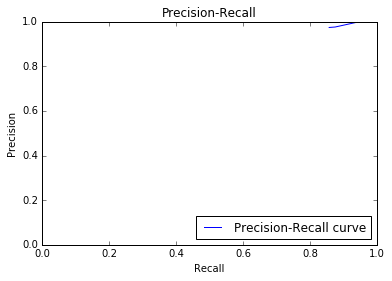

,country,range,result_range,errors,precision,recall
0,ES,165,165,4,0.975758,0.975758
0,NL,132,132,0,1.000000,1.000000
0,ZA,89,87,0,1.000000,0.977528
0,GR,39,39,0,1.000000,1.000000
0,IT,39,38,1,0.973684,0.948718
0,TR,21,21,0,1.000000,1.000000
0,BR,8,7,0,1.000000,0.875000
0,PL,7,6,0,1.000000,0.857143


In [14]:
# supervised execution
g_p1 = pd.DataFrame(pd_ex[pd_ex.columns[:6]])
g_p1.columns = ['partner_'+c for c in g_p1.columns]
g_p1 = g_p1.groupby('partner_country_code')
g_p2 = pd_ex[pd_ex.columns[6:]].groupby('partner_country_code')

# supervised data
sup_results_metrics, sup_result_df = run_on_grouped_by_country(g_p1, g_p2, True)

plt.clf()
plt.plot(sup_results_metrics['recall'].sort_values().values, sup_results_metrics['precision'].sort_values().values, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall')
plt.legend(loc="lower right")
plt.show()
sup_results_metrics.sort_values(by='result_range', ascending=False)

AD total: 17 , result: 17 , errors: 0 , pres: 1.0 , recall: 1.0
AE total: 115 , result: 114 , errors: 1 , pres: 0.991228070175 , recall: 0.982608695652
AR total: 53 , result: 53 , errors: 0 , pres: 1.0 , recall: 1.0
AT total: 168 , result: 166 , errors: 5 , pres: 0.969879518072 , recall: 0.958333333333
AU total: 344 , result: 341 , errors: 3 , pres: 0.991202346041 , recall: 0.982558139535
AW total: 4 , result: 3 , errors: 1 , pres: 0.666666666667 , recall: 0.5
BE total: 76 , result: 75 , errors: 1 , pres: 0.986666666667 , recall: 0.973684210526
BG total: 42 , result: 42 , errors: 0 , pres: 1.0 , recall: 1.0
BH total: 17 , result: 17 , errors: 0 , pres: 1.0 , recall: 1.0
BR total: 22 , result: 22 , errors: 0 , pres: 1.0 , recall: 1.0
CA total: 186 , result: 183 , errors: 3 , pres: 0.983606557377 , recall: 0.967741935484
CH total: 180 , result: 179 , errors: 1 , pres: 0.994413407821 , recall: 0.988888888889
CL total: 3 , result: 3 , errors: 0 , pres: 1.0 , recall: 1.0
CN total: 145 , res

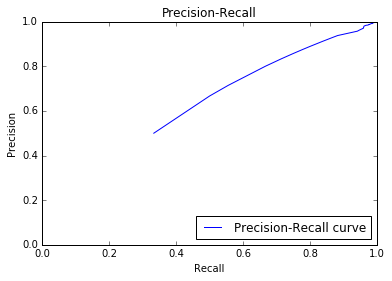

,country,range,result_range,errors,precision,recall
0,US,2081,2062,25,0.987876,0.978856
0,FR,1432,1418,17,0.988011,0.978352
0,DE,848,840,11,0.986905,0.977594
0,ES,842,834,11,0.986811,0.977435
0,IT,675,672,6,0.991071,0.986667


In [15]:
# unsupervised execution
g_p1 = pd_p1.groupby('partner_country_code')
g_p2 = pd_p2.groupby('partner_country_code')

unsup_results_metrics, unsup_result_df = run_on_grouped_by_country(g_p1, g_p2)

plt.clf()
plt.plot(unsup_results_metrics['recall'].sort_values().values, unsup_results_metrics['precision'].sort_values().values, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall')
plt.legend(loc="lower right")
plt.show()
unsup_results_metrics.sort_values(by='result_range', ascending=False).head()

In [71]:
unsup_result_df.head()

,partner_hotel_name_x,partner_country_code_x,partner_city_name_x,partner_star_rating_x,partner_latitude_x,partner_longitude_x,0,1,2,3,partner_hotel_name_y,partner_country_code_y,partner_city_name_y,partner_star_rating_y,partner_latitude_y,partner_longitude_y
1362,Xalet BesolÃ­ Atiram Hotel,AD,Erts,3.0,42.568497,1.489474,139,1362,0.0,100,Xalet BesolÃ­,AD,Arinsal,3.0,42.568498,1.489474
4079,Holiday Inn Andorra Hotel,AD,Andorra La Vella,4.0,42.505927,1.520405,140,4079,0.0,100,Holiday Inn Andorra,AD,Andorra la Vella,5.0,42.505721,1.519745
5945,Hotel La Cabana,AD,Ordino,3.0,42.552970,1.533172,142,5945,0.0,100,HolaStays Hotel La Cabana,AD,Ordino,3.0,42.552970,1.533172
2347,Hesperia Andorra la Vella,AD,Andorra La Vella,4.0,42.509070,1.529295,146,2347,0.0,100,Hesperia Andorra,AD,Andorra la Vella,4.0,42.509090,1.529229
3993,Somriu Hotel Cassany,AD,Andorra La Vella,3.0,42.507862,1.524753,147,3993,0.0,100,Hotel Cassany,AD,Andorra la Vella,3.0,42.507860,1.524753


In [67]:
unsup_result_df.to_csv('matches.csv', columns=[0,1], header=['Partner1','Partner2'], index=False)

In [77]:
unsup_result_df_excel = unsup_result_df
unsup_result_df_excel[0] = unsup_result_df_excel[0].add(2)
unsup_result_df_excel[1] = unsup_result_df_excel[1].add(2)
unsup_result_df_excel.to_csv('matches_as_excel_lines.csv', columns=[0,1], header=['Partner1','Partner2'], index=False)